In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy.random as npr
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, precision_recall_curve, roc_curve, r2_score, ConfusionMatrixDisplay, auc, roc_auc_score, precision_score, recall_score
import seaborn as sns
from sklearn import metrics
import joblib
import time
from tqdm import tqdm 

In [21]:
df = pd.read_csv("./dataset.csv")

feature_names = df.columns.tolist()
print(feature_names)

['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


In [23]:
X = df.drop(columns=['status', 'name'])
t = df['status'].astype(int)

In [24]:
# if the data and the target a seperate:
#df = pd.concat([data,target], axis 1)

# get the pearons correlation coefficient 
corr_matrix = df.corr(method='pearson', numeric_only=True)

# get the largest correlated feature 
target = 'status'
best_feature = corr_matrix[target].drop(target).idxmax()
print(f"Feature with the largest predictive value for Target is: '{best_feature}'")

# get the value of the highest corrleted feature 
highest_cor_feat = corr_matrix[target].drop(target).max()
print(f"The Pearson Coefficent Value is: {highest_cor_feat:.2f} ")

# print the Correlation Values by order 
corr_matrix[target].sort_values(ascending=False)

Feature with the largest predictive value for Target is: 'spread1'
The Pearson Coefficent Value is: 0.54 


status              1.000000
spread1             0.539539
PPE                 0.504797
spread2             0.433070
MDVP:Shimmer        0.349813
MDVP:APQ            0.345310
Shimmer:APQ5        0.337126
MDVP:Shimmer(dB)    0.335911
Shimmer:APQ3        0.333282
Shimmer:DDA         0.329220
D2                  0.326976
MDVP:Jitter(Abs)    0.321233
RPDE                0.292920
MDVP:PPQ            0.276525
MDVP:Jitter(%)      0.268528
Jitter:DDP          0.252708
MDVP:RAP            0.250416
DFA                 0.220340
NHR                 0.179734
MDVP:Fhi(Hz)       -0.159528
HNR                -0.345324
MDVP:Flo(Hz)       -0.362129
MDVP:Fo(Hz)        -0.362827
Name: status, dtype: float64

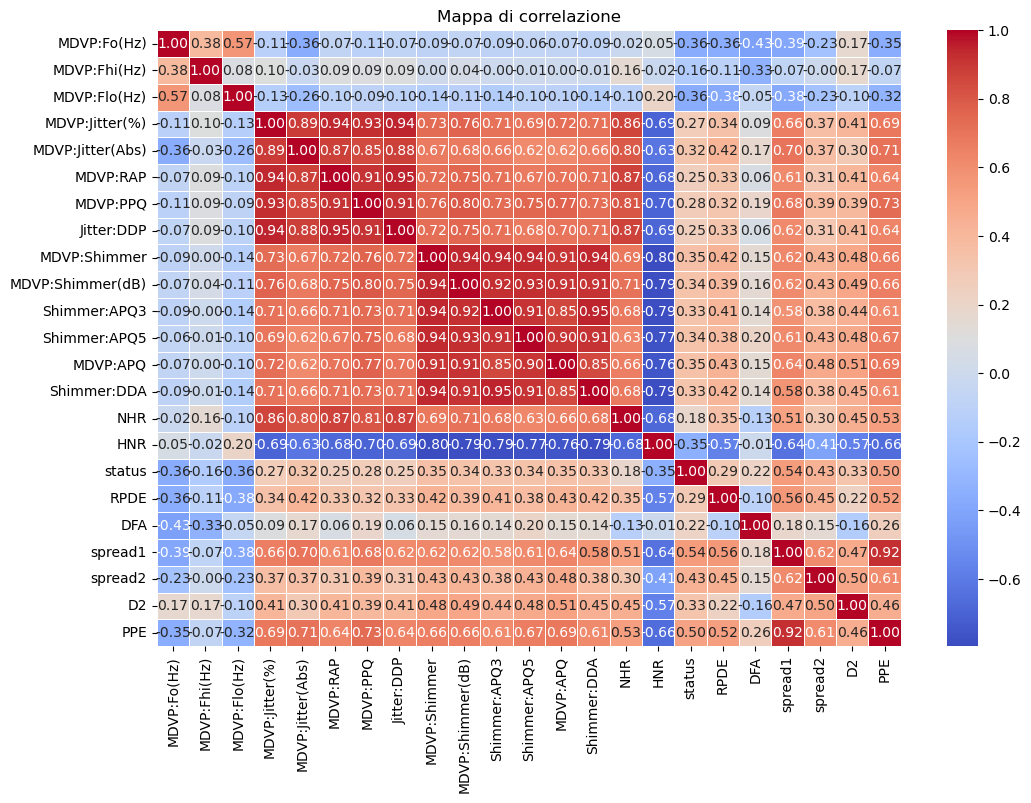

In [25]:
# Crea una heatmap utilizzando Seaborn
plt.figure(figsize=(12, 8))  # Dimensione del grafico
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mappa di correlazione')
plt.show()

In [38]:
# PIPELINE: If the data is seperated in Data X and Target y
X_train, X_test, t_train, t_test = train_test_split(X, t, 
                                                    test_size =0.2,
                                                    random_state=42,
                                                    shuffle=True, 
                                                    stratify=t)

In [28]:
from xgboost import XGBClassifier

xg_clf = XGBClassifier(objective='binary:logistic', random_state=42)

# Suddivisione del dataset in train-val e test
x_trainval, x_test, y_trainval, y_test = train_test_split(X, t, test_size=0.2, random_state=42)

# Suddivisione del train-val in train e validation

x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size=0.25, random_state=42)

# Inizializzazione del modello XGBoost
xg_clf = XGBClassifier(objective='binary:logistic', random_state=42)

# Definizione del parametro per la GridSearchCV
param_grid = {
    'colsample_bytree': [0.2, 0.3, 0.4],
    'n_estimators': [50, 75, 100, 150, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'alpha': [5, 10, 20],
}

# Ricerca degli iperparametri tramite GridSearchCV sui dati di train 
grid_search = GridSearchCV(xg_clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)  # Fit sulla parte di training

# Miglior modello
best_xg_clf = grid_search.best_estimator_

# Predizione sul test set
y_pred = best_xg_clf.predict(x_test)


/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [29]:
# Valutare le prestazioni del modello sul test set
y_pred = best_xg_clf.predict(x_train)
precision = precision_score(y_train, y_pred)
print("Precision:", precision)

# Report di classificazione
print(classification_report(y_train, y_pred))

Precision: 0.9883720930232558
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       629
           1       0.99      0.97      0.98        88

    accuracy                           0.99       717
   macro avg       0.99      0.98      0.99       717
weighted avg       0.99      0.99      0.99       717



In [30]:
# Valutare le prestazioni del modello sul test set
y_pred = best_xg_clf.predict(x_test)
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Report di classificazione
print(classification_report(y_test, y_pred))

Precision: 0.8846153846153846
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       213
           1       0.88      0.88      0.88        26

    accuracy                           0.97       239
   macro avg       0.94      0.94      0.94       239
weighted avg       0.97      0.97      0.97       239



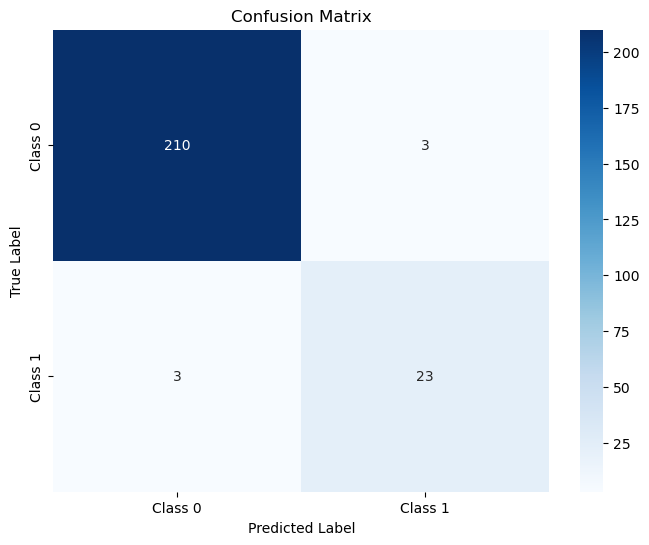

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [43]:
classifier = {
    "SVM": Pipeline(steps=[('scaler', StandardScaler()),
                           ('svm',SVC(kernel='rbf'))]),
    "rf": Pipeline(steps=[('scaler', StandardScaler()),
                                     ('rf', RandomForestClassifier())])   
}

param_grids = {
    "SVM": {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': [0.001, 0.01, 0.1, 1]
        },
    "rf": {
        'rf__n_estimators': [10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220],
        'rf__criterion': ['gini', 'entropy'],
        'rf__max_depth': [5,6,7]
        }
}

for name, classifier in classifier.items():
    print("Training:", name)
    # Set up GridSearchCV with cross-validation

    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grids[name],
        cv=KFold(n_splits=5, shuffle=True, random_state=0),
        scoring='accuracy',  # Choose appropriate scoring metric
        refit=True,
        n_jobs=-1  # Use all available cores for parallel processing
        )
    
    start_time = time.time()
    with tqdm(total=1, desc=f"Fitting {name}") as pbar:
        grid_search.fit(X_train, t_train)
        pbar.update(1) 
    training_time = time.time() - start_time
    
    # Fit the model
    #start_time = time.time()
    #grid_search.fit(X_train, t_train)
    #training_time = time.time() - start_time

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    
    # Get the best parameters 
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    
    # Store results
    results = {
        'Classifier': name,
        'Best Parameters': best_params,
        'Model': best_model,
        'Training Time': training_time
    }
    
    model_filename = f"{name.lower()}_model.pkl"
    joblib.dump(results, model_filename)


Training: SVM


Fitting SVM: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Best Parameters: {'svm__C': 10, 'svm__gamma': 0.1}
Training: rf


Fitting rf: 100%|██████████| 1/1 [00:44<00:00, 44.94s/it]

Best Parameters: {'rf__criterion': 'gini', 'rf__max_depth': 7, 'rf__n_estimators': 100}


In [53]:
svm_model = joblib.load('svm_model.pkl')
best_model = joblib.load('rf_model.pkl')

In [54]:
y_train = best_model['Model'].predict(X_train)
y_test = best_model['Model'].predict(X_test)

Training set performance:
Accuracy: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       838
           1       1.00      1.00      1.00       118

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

Accuracy: 1.000
Test set performance:
Accuracy: 0.979
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       210
           1       0.88      0.97      0.92        29

    accuracy                           0.98       239
   macro avg       0.94      0.97      0.95       239
weighted avg       0.98      0.98      0.98       239

Accuracy: 0.979


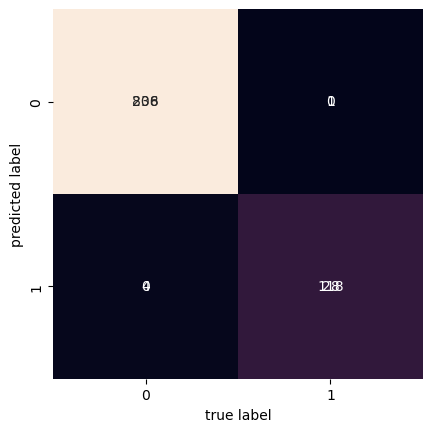

In [55]:
# TRAINING SET 
print('Training set performance:')

# ACCURACY AND CLASSIFICATION REPORT
accuracy = metrics.accuracy_score(t_train, y_train)
print("Accuracy: %.3f" % accuracy)
print(classification_report(t_train, y_train))

# CONFUION MATRIX FOR THE TEST SET
accuracy = metrics.accuracy_score(t_train, y_train)
print("Accuracy: %.3f" % accuracy)

cm = metrics.confusion_matrix(t_train, y_train)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# TEST SET 
print('Test set performance:')

# ACCURACY AND CLASSIFICATION REPORT
accuracy = metrics.accuracy_score(t_test, y_test)
print("Accuracy: %.3f" % accuracy)
print(classification_report(t_test, y_test))

# CONFUION MATRIX FOR THE TEST SET
accuracy = metrics.accuracy_score(t_test, y_test)
print("Accuracy: %.3f" % accuracy)

cm = metrics.confusion_matrix(t_test, y_test)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');


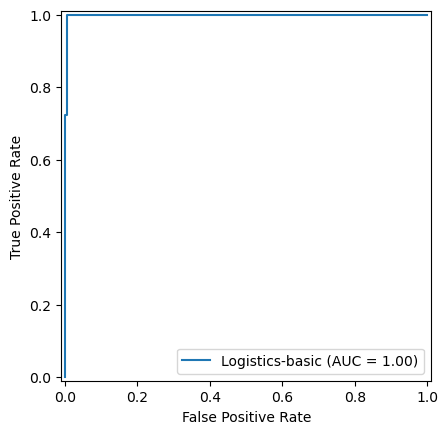

In [42]:
# Plot ROC/AUC curve
fpr, tpr, thresholds = metrics.roc_curve(t_test,best_model.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='Logistics-basic')
display.plot()

plt.show()

In [ ]:
# For single class predictions using cross-validation
z_train = cross_val_predict(pipeline, X_train, t_train, 
                             cv=10, method='decision_function')

precision, recall, thresholds = precision_recall_curve(t_train, z_train)

plt.plot(recall, precision)
plt.xlabel('Recall', size=15)
plt.ylabel('Precision', size=15);

NameError: name 'pipeline' is not defined

Training set performance:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       838
           1       1.00      1.00      1.00       118

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

Test set performance:
Accuracy: 0.979
Precision: 0.875
Recall: 0.966
F1 Score: 0.918
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       210
           1       0.88      0.97      0.92        29

    accuracy                           0.98       239
   macro avg       0.94      0.97      0.95       239
weighted avg       0.98      0.98      0.98       239



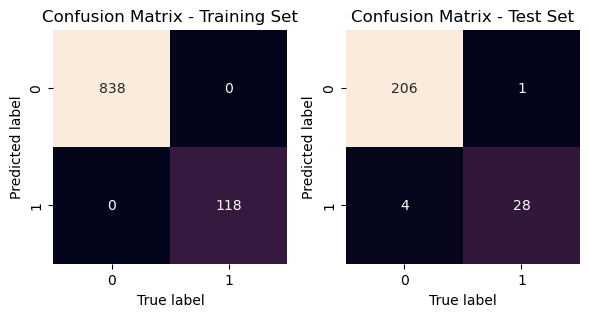

In [46]:
# TRAINING SET PERFORMANCE
print('Training set performance:')
accuracy_train = metrics.accuracy_score(t_train, y_train)
print("Accuracy: %.3f" % accuracy_train)
precision_train = metrics.precision_score(t_train, y_train)
print("Precision: %.3f" % precision_train)
recall_train = metrics.recall_score(t_train, y_train)
print("Recall: %.3f" % recall_train)
f1_train = metrics.f1_score(t_train, y_train)
print("F1 Score: %.3f" % f1_train)
print(metrics.classification_report(t_train, y_train))

# TEST SET PERFORMANCE
print('Test set performance:')
accuracy_test = metrics.accuracy_score(t_test, y_test)
print("Accuracy: %.3f" % accuracy_test)
precision_test = metrics.precision_score(t_test, y_test)
print("Precision: %.3f" % precision_test)
recall_test = metrics.recall_score(t_test, y_test)
print("Recall: %.3f" % recall_test)
f1_test = metrics.f1_score(t_test, y_test)
print("F1 Score: %.3f" % f1_test)
print(metrics.classification_report(t_test, y_test))

# Create a figure with 1 row and 2 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

# Confusion Matrix for the Training Set
cm_train = metrics.confusion_matrix(t_train, y_train)
sns.heatmap(cm_train.T, square=True, annot=True, fmt='d', cbar=False, ax=axes[0])
axes[0].set_xlabel('True label')
axes[0].set_ylabel('Predicted label')
axes[0].set_title('Confusion Matrix - Training Set')

# Confusion Matrix for the Test Set
cm_test = metrics.confusion_matrix(t_test, y_test)
sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False, ax=axes[1])
axes[1].set_xlabel('True label')
axes[1].set_ylabel('Predicted label')
axes[1].set_title('Confusion Matrix - Test Set')

# Display the plot
plt.tight_layout()
plt.show()